In [31]:
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

SHOW_RATIO = True

def bar_chart(ax, algorithms, normalize_by=None, draw_line=False, in_percents=False):
    if normalize_by is not None:
        factor = 100 if in_percents else 1
    names = [x['algorithm']['name'] for x in algorithms]
    expected_results = [x.get('expected_makespan') for x in algorithms]
    actual_results = [x['makespan'] for x in algorithms]
    if SHOW_RATIO:
        ratios = [x['exec_time'] / (x['exec_time']+x['comm_time']) for x in algorithms]
    else:
        ratios = [None] * len(algorithms)
    if normalize_by:
        actual_results = [x/normalize_by for x in actual_results]
        expected_results = [x/normalize_by for x in expected_results]
        if draw_line:
            plt.plot([-0.5, len(names)-0.5], [1, 1], color='#C44E52', linewidth=4)
    for i, (expected, actual, ratio) in enumerate(zip(expected_results, actual_results, ratios)):
        if not math.isnan(expected):
            ax.add_patch(Rectangle((-0.4+i, 0), 0.38, expected*factor, color='#55A868'))
            if SHOW_RATIO:
                ax.add_patch(Rectangle(( 0.02 +i, 0), 0.38, actual*ratio*factor, color='#DD8452'))
                ax.add_patch(Rectangle(( 0.02 +i, actual*ratio*factor), 0.38, actual*(1-ratio)*factor, color='#4C72B0'))
            else:
                ax.add_patch(Rectangle(( 0.02 +i, 0), 0.38, actual*factor, color='#4C72B0'))
        else:
            ax.add_patch(Rectangle((-0.4+i, 0), 0.8, actual*factor, color='#4C72B0'))
    plt.xlim(-0.5, len(names)-0.5)
    plt.xticks(range(len(names)), names)

In [32]:
def get_name_by_path(path):
    return path.split("/")[-1].rsplit('.', 1)[0]

def platform_sort_key(item):
    return platform_order.index(get_name_by_path(item[0]))

def algo_sort_key(item):
    return algo_order.index(item['algorithm']['name'])

def algo_item_sort_key(item):
    return algo_order.index(item[0])

def humanize_workflow_name(wf_name):
    return wf_name.split('_')[0]

platform_order = [
    'platform_rack_4', 'platform_rack_8', 'platform_rack_16',
    'platform_cluster_2', 'platform_cluster_4', 'platform_cluster_8',
    'simple_4',
]
platform_names = {
    'simple_4': '4 ядра x 4 хоста, полносвязный',
    'platform_rack_4': '4 ядра x 4 хоста x 1 стойка',
    'platform_rack_8': '2 ядра x 8 хостов x 1 стойка',
    'platform_cluster_2': '4 ядра x 2 хоста x 2 стойки',
    'platform_cluster_4': '2 ядра x 4 хоста x 2 стойки',
}
algo_order = ['HEFT', 'EHEFT', 'EHEFT_caching', 'LA', 'ELA', 'ELA_caching']
algo_colors = {
    'HEFT': '#5975A4',
    'EHEFT': '#CC8963',
    'EHEFT_caching': '#5F9E6E',
    'LA': '#B55D60',
    'ELA': '#857AAB',
    'ELA_caching': '#8D7866',
}

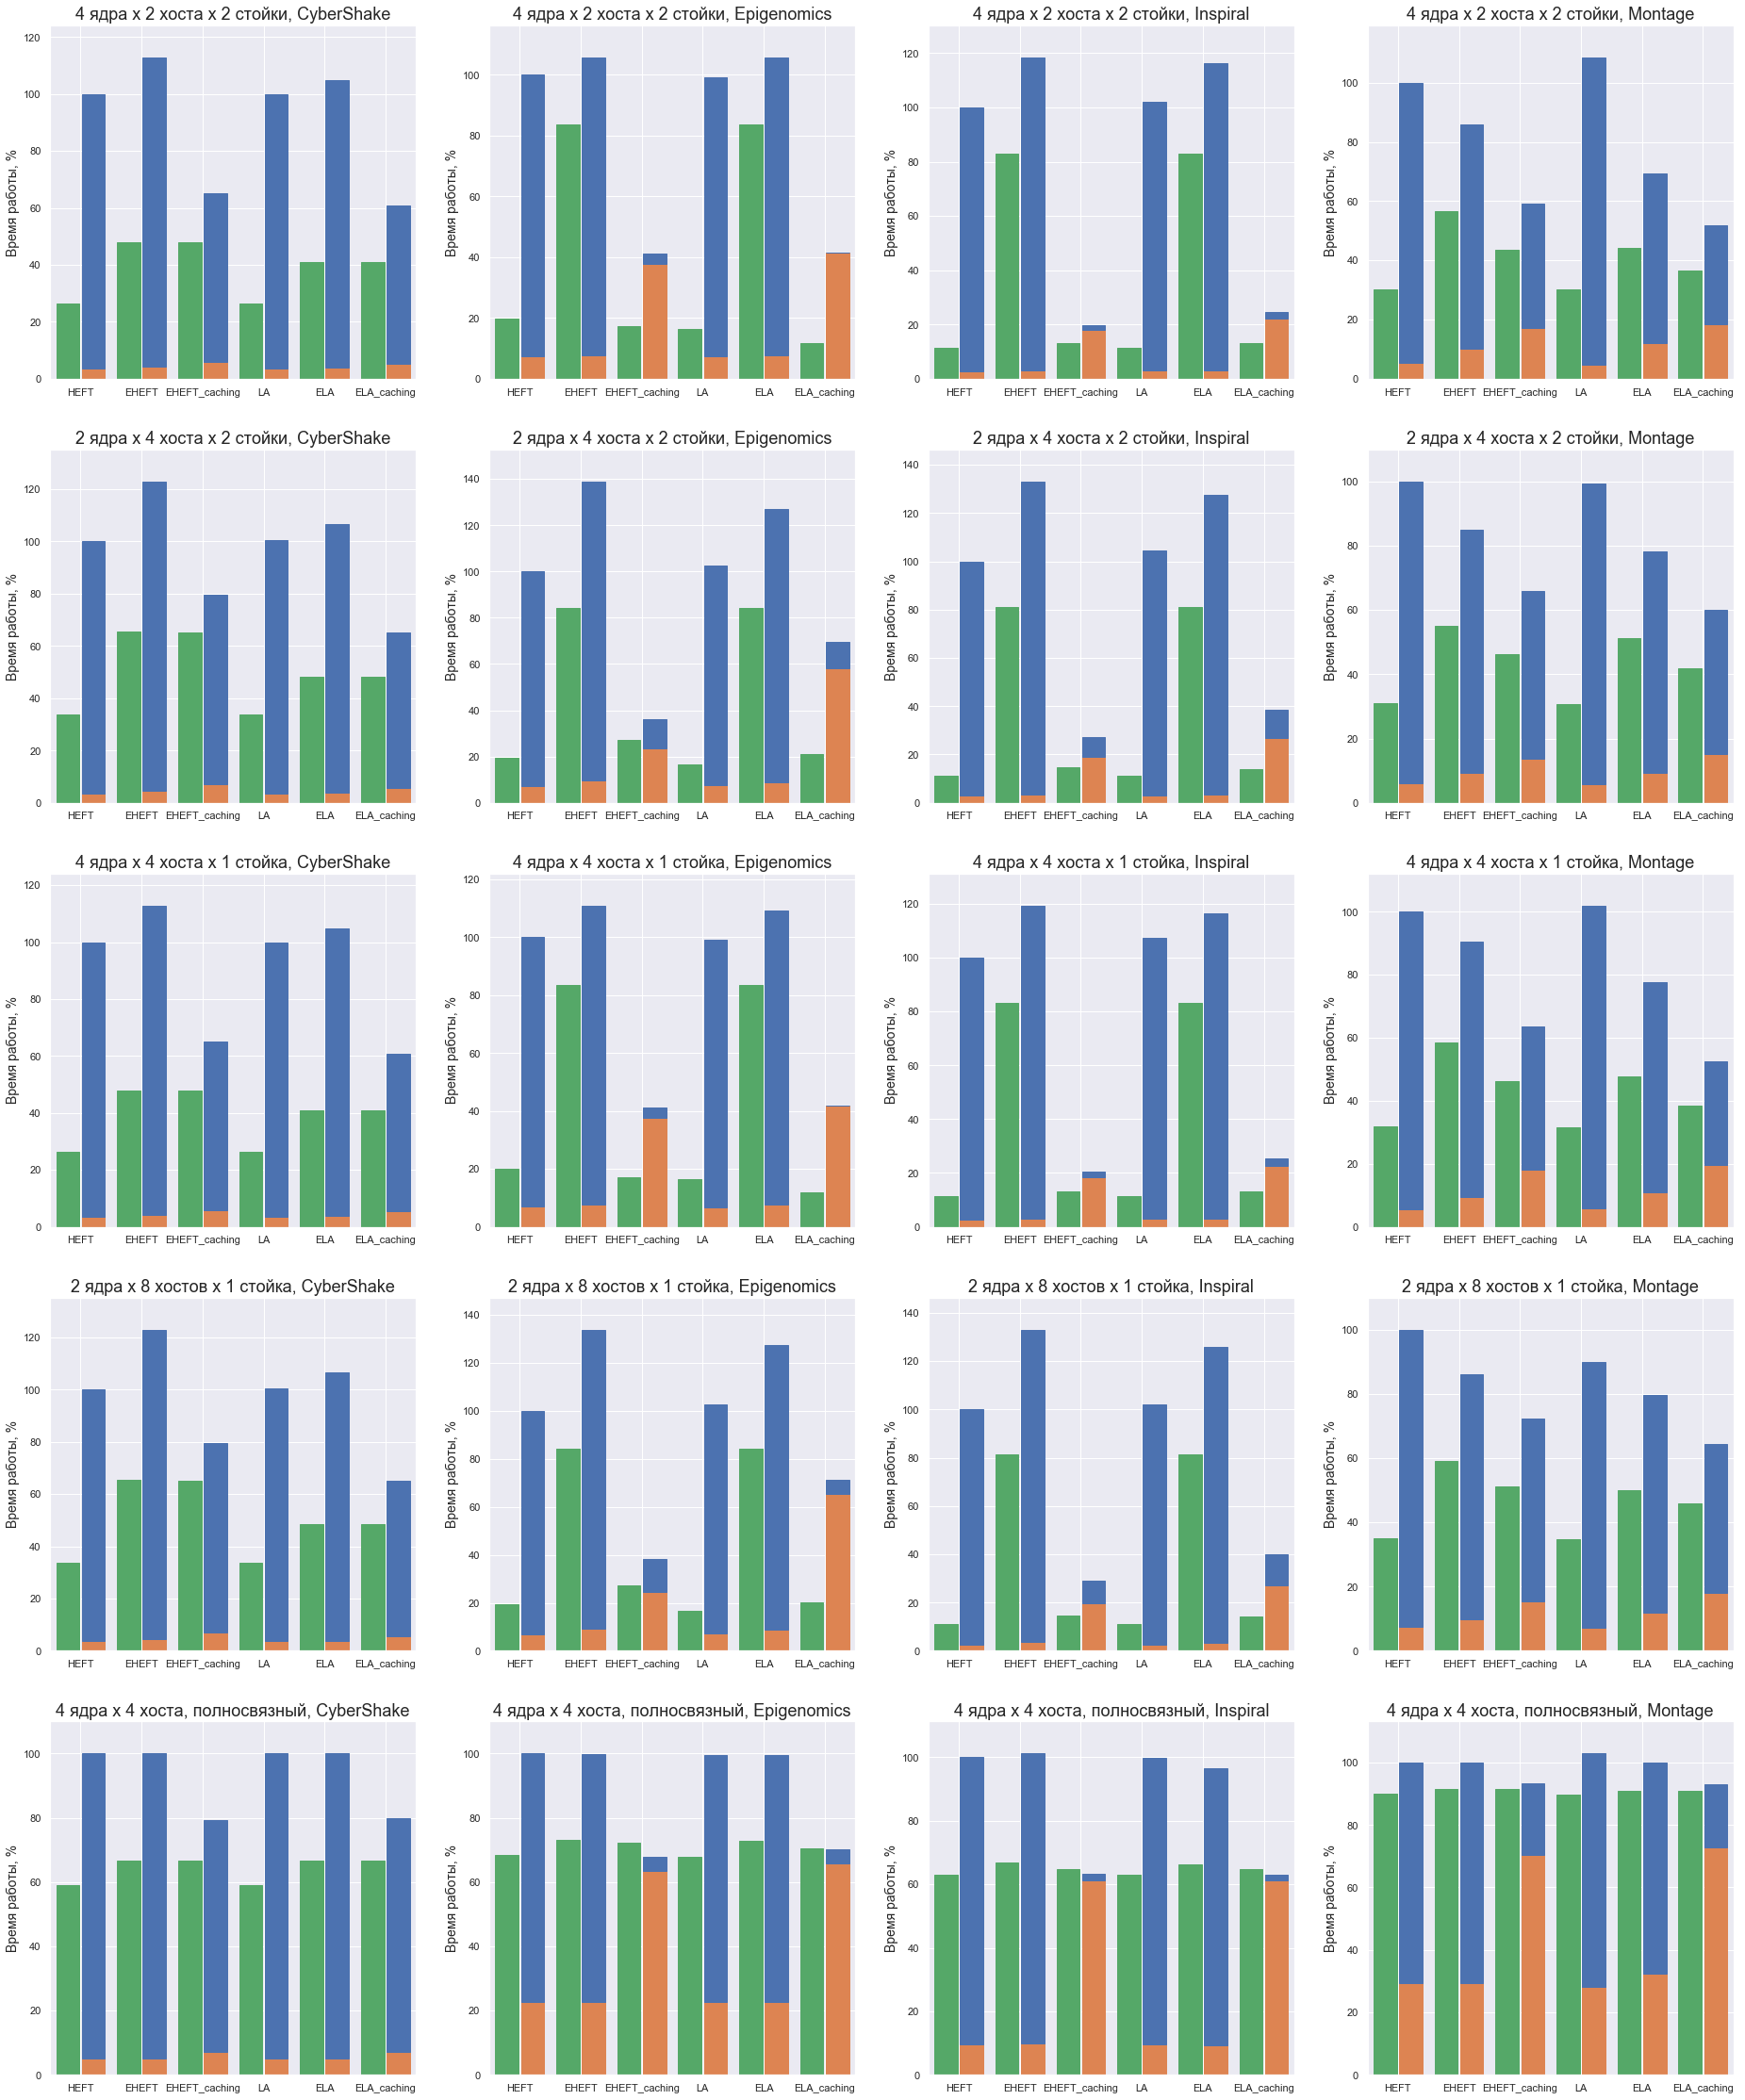

In [34]:
import json
results = json.load(open('output'))
for x in results:
    x['tasks'] = get_name_by_path(x['tasks'])
    x['platform'] = get_name_by_path(x['platform'])
    
by_platform_and_worflow = {}
for r in results:
    by_platform_and_worflow.setdefault(r['platform'], {})
    by_platform_and_worflow[r['platform']].setdefault(r['tasks'], [])
    by_platform_and_worflow[r['platform']][r['tasks']].append(r)

plt.figure(figsize=(32, 40))
counter = 1
for i, (platform, platform_results) in enumerate(sorted(by_platform_and_worflow.items())):
    for j, (workflow, workflow_results) in enumerate(sorted(platform_results.items())):
        ax = plt.subplot(len(by_platform_and_worflow), len(platform_results), counter)
        max_res = max([x['makespan'] for x in workflow_results])
        sorted_results = sorted(workflow_results, key=algo_sort_key)
        bar_chart(ax, sorted_results, normalize_by=sorted_results[0]['makespan'], in_percents=True)
        plt.ylim(bottom=0, top=max_res/sorted_results[0]['makespan']*1.1*100)
        platform = get_name_by_path(platform)
        workflow = get_name_by_path(workflow)
        plt.title(f'{platform_names[platform]}, {humanize_workflow_name(workflow)}', fontsize=18)
        plt.ylabel('Время работы, %', fontsize=14)
        counter += 1